In [1]:
import idaes

print("IDAES version: ", idaes.__version__)

IDAES version:  2.5.0


In [2]:
from compressor import setup_compressor_model, report_compressor_properties

# Create and solve the model
model, results = setup_compressor_model(
    flow_mol=100,  # mol/s
    mole_frac_methane=1.0,
    pressure=101325,  # Pa
    temperature=298,  # K
)

prop = report_compressor_properties(model)

6
0
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

c:\Users\desai\Downloads\01 GITHUB Repo\IDAES-PSE-Examples\Compressor\gas.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "a0": (Cp_data_Poling.loc["74-82-8"][3], None),
c:\Users\desai\Downloads\01 GITHUB Repo\IDAES-PSE-Examples\Compressor\gas.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "a1": (Cp_data_Poling.loc["74-82-8"][4], pyunits.K**-1),
c:\Users\desai\Downloads\01 GITHUB Repo\IDAES-PSE-Examples\Compressor\gas.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

In [3]:
# Visualize (if needed)
model.fs.visualize("Compressor Model")

2025-09-12 06:10:32 [INFO] idaes.idaes_ui.fv.fsvis: Started visualization server
2025-09-12 06:10:32 [INFO] idaes.idaes_ui.fv.fsvis: Saving flowsheet to default file 'Compressor Model.json' in current directory (c:\Users\desai\Downloads\01 GITHUB Repo\IDAES-PSE-Examples\Compressor)
2025-09-12 06:10:32 [WARNING] idaes.idaes_ui.fv.fsvis: Flowsheet name changed: old='Compressor Model' new='Compressor-Model'
Flowsheet name changed to 'Compressor-Model'
2025-09-12 06:10:32 [INFO] idaes.idaes_ui.fv.fsvis: Flowsheet visualization at: http://localhost:58317/app?id=Compressor-Model


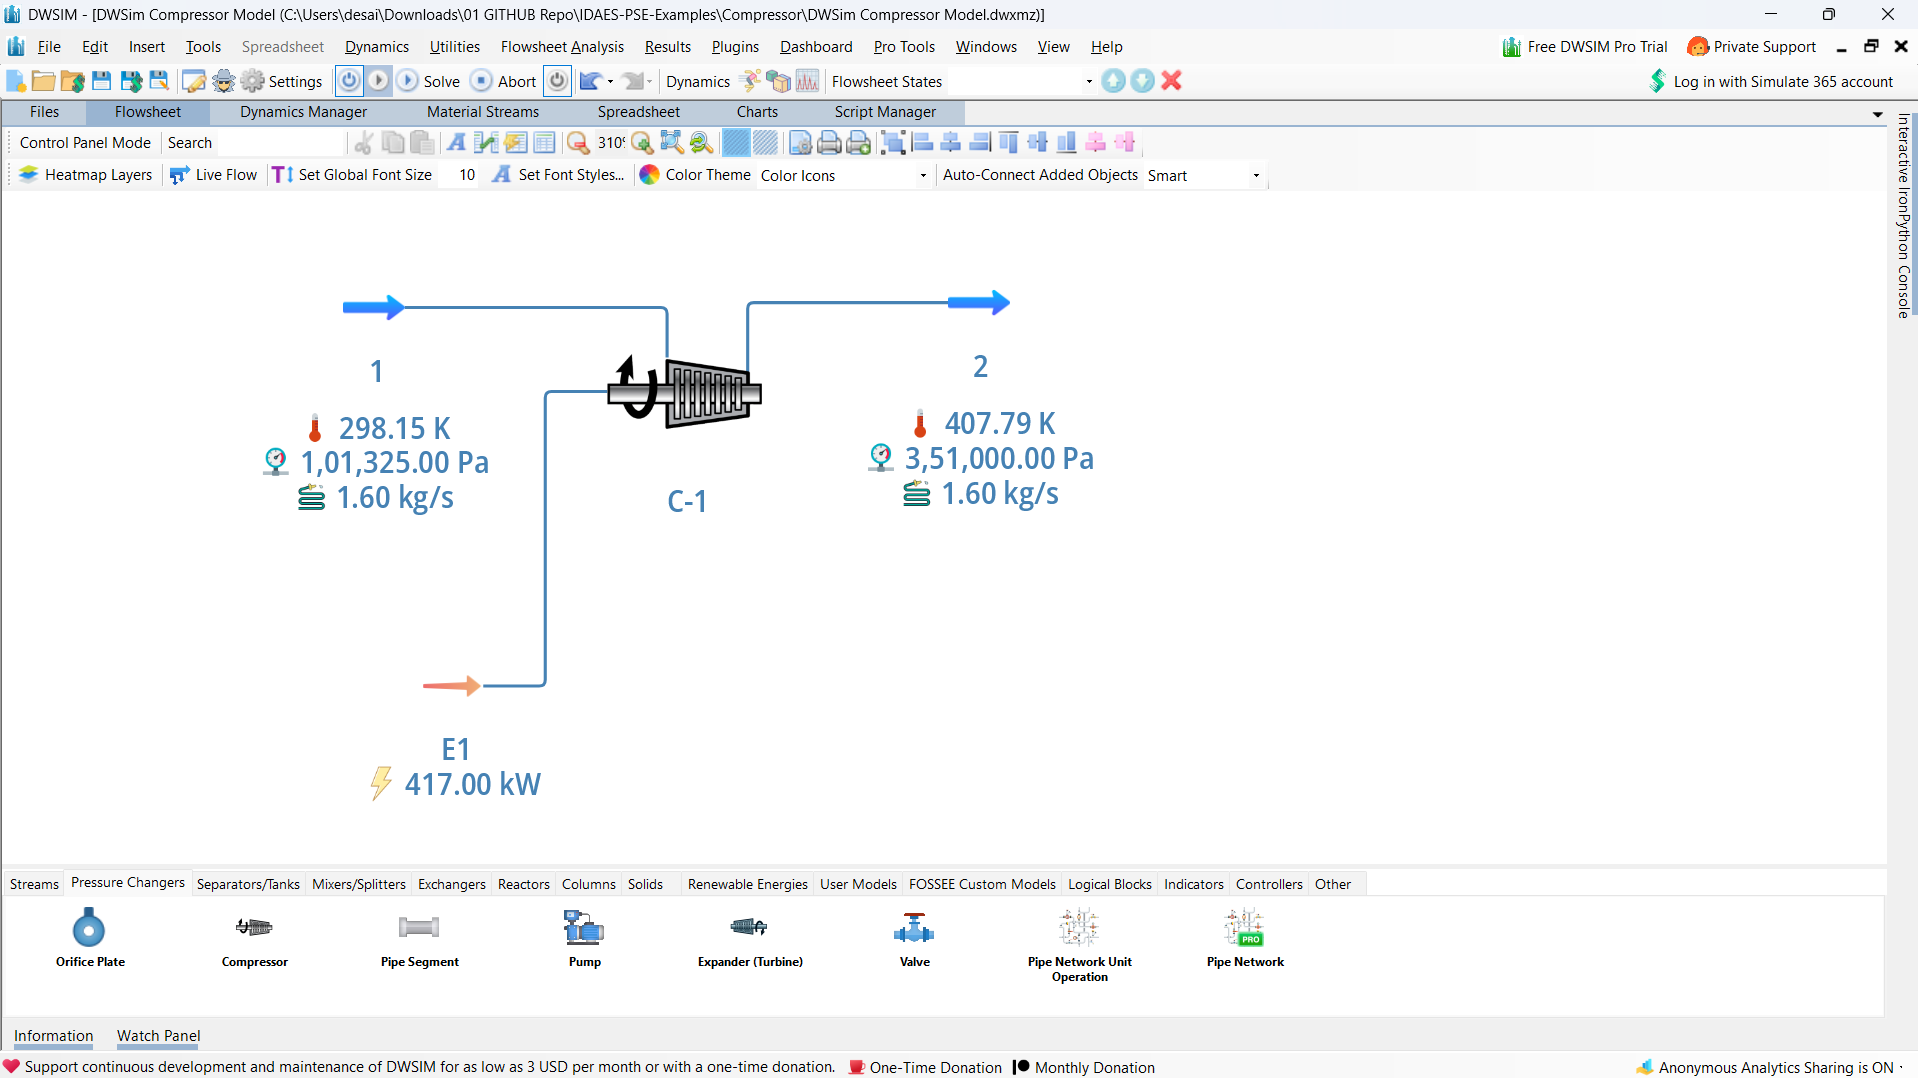

In [6]:
from IPython.display import Image
Image(filename=r'C:\Users\desai\Downloads\01 GITHUB Repo\IDAES-PSE-Examples\Compressor\DWSim Compressor.png')

In [7]:
import webbrowser
import tempfile
import os

def display_image_in_browser(image_path, title="Image Viewer"):
    # Create a temporary HTML file that embeds the image
    html_content = f"""
    <html>
        <head>
            <title>{title}</title>
        </head>
        <body style="text-align: center;">
            <h2>{title}</h2>
            <img src="file://{os.path.abspath(image_path)}" style="max-width:90%; max-height:90%;">
        </body>
    </html>
    """
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
        f.write(html_content)
        temp_html_path = f.name

    webbrowser.open(f'file://{temp_html_path}')


In [8]:
display_image_in_browser("DWSim Flash.png", title="DWSim Flash Operation Model Check")